In [1]:
using Revise, OrdinaryDiffEq, Flux, DiffEqFlux, Optim
using Plots, FileIO, JLD2, OffsetArrays, ProgressMeter, Kinetic

┌ Error: (compiled mode) evaluation error starting at /home/vavrines/.julia/packages/DistributionsAD/BtYLj/src/reversediff.jl:19
│   mod = DistributionsAD.ReverseDiffX
│   ex = begin
    #= /home/vavrines/.julia/packages/DistributionsAD/BtYLj/src/reversediff.jl:19 =#
    const RDBroadcasted{F, T} = Broadcasted{<:Any, <:Any, F, T}
end
│   exception = (ErrorException("invalid redefinition of constant RDBroadcasted"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f6b190f972f, Ptr{Nothing} @0x00007f6b1918694c, Ptr{Nothing} @0x00007f6b191890f8, Ptr{Nothing} @0x00007f6b19189fe7, Base.InterpreterIP in top-level CodeInfo for DistributionsAD.ReverseDiffX at statement 15])
└ @ Revise /home/vavrines/.julia/packages/Revise/BqeJF/src/lowered.jl:85


In [82]:
@load "sol1d.jld2" ks ctr

2-element Array{Symbol,1}:
 :ks
 :ctr

In [44]:
vMeshType = "rectangle"
umin = ks.vSpace.u0
umax = ks.vSpace.u1
nu = ks.vSpace.nu
vmin = ks.vSpace.u0
vmax = ks.vSpace.u1
nv = 28
nvg = 0
wmin = ks.vSpace.u0
wmax = ks.vSpace.u1
nw = 28
nwg = 0
nm = 5
tLen = 3
nh = 12;

In [45]:
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType)

kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, ks.gas.γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length = tLen);

In [84]:
#--- Boltzmann dataset ---#
f_full = Array{Float32}(undef, ks.vSpace.nu, nv, nw, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    f_full[:, :, :, i] .= full_distribution(
        ctr[i].h,
        ctr[i].b,
        ks.vSpace.u,
        ks.vSpace.weights,
        vSpace3D.v,
        vSpace3D.w,
        ctr[i].prim,
        ks.gas.γ,
    )
end

phi, psi, phipsi = kernel_mode(
    nm,
    vSpace3D.u1,
    vSpace3D.v1,
    vSpace3D.w1,
    vSpace3D.du[1, 1, 1],
    vSpace3D.dv[1, 1, 1],
    vSpace3D.dw[1, 1, 1],
    vSpace3D.nu,
    vSpace3D.nv,
    vSpace3D.nw,
    ks.gas.αᵣ,
)

function boltzmann(f, p, t)
    Kn, M, phi, psi, phipsi = p
    return boltzmann_fft(f[1:end,1:end,1:end], Kn, M, phi, psi, phipsi)
end

function boltzmann!(df, f, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

data_boltz = zeros(Float32, ks.vSpace.nu, nv, nw, ks.pSpace.nx, tLen)
for i = 1:ks.pSpace.nx
    prob = ODEProblem(
        boltzmann!,
        f_full[:, :, :, i],
        tspan,
        [kn_bzm, nm, phi, psi, phipsi],
    )

    data_boltz[:, :, :, i, :] = solve(prob, Tsit5(), saveat = tran) |> Array
end

h_boltz = zeros(Float32, ks.vSpace.nu, ks.pSpace.nx, tLen)
b_boltz = zeros(Float32, ks.vSpace.nu, ks.pSpace.nx, tLen)
for j = 1:tLen, i = 1:ks.pSpace.nx
    h_boltz[:, i, j], b_boltz[:, i, j] = reduce_distribution(
        data_boltz[:, :, :, i, j],
        vSpace3D.v,
        vSpace3D.w,
        vSpace2D.weights,
    )
end
Y = vcat(h_boltz, b_boltz);

In [87]:
#--- BGK dataset ---#
function bgk!(df, f, p, t)
    H, B, tau = p
    df[1:end÷2, :] .= (H .- f[1:end÷2, :]) ./ tau
    df[end÷2+1:end, :] .= (B .- f[end÷2+1:end, :]) ./ tau
end

X = Array{Float32}(undef, nu * 2, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    X[1:nu, i] .= ctr[i].h
    X[nu+1:end, i] .= ctr[i].b
end

H = Array{Float32}(undef, nu, ks.pSpace.nx)
B = Array{Float32}(undef, nu, ks.pSpace.nx)
τ = Array{Float32}(undef, 1, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    H[:, i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
    B[:, i] .= H[:, i] .* ks.gas.K ./ (2.0 .* ctr[i].prim[end])
    τ[1, i] = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
end
P = [H, B, τ]

prob = ODEProblem(bgk!, X, tspan, P)
Y1 = solve(prob, Midpoint(), saveat = tran) |> Array;

#=
qf = Array{Float32}(undef, ks.pSpace.nx)
SH = Array{Float32}(undef, nu, ks.pSpace.nx)
SB = Array{Float32}(undef, nu, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    qf[i] = heat_flux(ctr[i].h, ctr[i].b, ctr[i].prim, ks.vSpace.u, ks.vSpace.weights)
    SH[:, i], SB[:, i] = shakhov(ks.vSpace.u, H[:, i], B[:, i], qf[i], ctr[i].prim, ks.gas.Pr, ks.gas.K)
    SH[:, i] .+= H[:, i] .+ SH[:, i]
    SB[:, i] .+= B[:, i] .+ SB[:, i]
end
PS = [SH, SB, τ];
=#

96×50×3 Array{Float32,3}:
[:, :, 1] =
 0.0          -8.62334f-13  -1.01498f-12  …  -6.31271f-14  3.25519f-24
 0.0           3.07361f-13   3.35859f-13      3.54352f-14  2.09243f-22
 0.0           1.22118f-12   1.25786f-12     -1.67577f-14  1.13805f-20
 0.0          -8.5086f-13   -8.6219f-13      -3.86033f-14  5.23732f-19
 5.6f-44      -9.16916f-13  -9.24898f-13      4.47824f-13  2.03935f-17
 1.88221f-40   2.24548f-11   2.2861f-11   …  -2.26154f-12  6.71912f-16
 4.46445f-37  -4.4555f-11   -4.65967f-11      8.12398f-12  1.87313f-14
 7.48289f-34   3.56334f-11   3.91497f-11     -2.23086f-11  4.41835f-13
 8.86287f-31  -1.17641f-11  -1.39135f-11      6.15249f-11  8.81837f-12
 7.41794f-28   1.17874f-12   1.77566f-12      4.5586f-11   1.4892f-10
 4.38727f-25   2.7523f-12    2.79068f-12  …   2.31784f-9   2.12791f-9
 1.83362f-22  -4.15523f-12  -4.03865f-12      2.55441f-8   2.5727f-8
 5.41537f-20   2.6023f-13   -8.12107f-13      2.64508f-7   2.63186f-7
 ⋮                                        ⋱ 

In [111]:
#--- universal differential equation ---#
model_univ = FastChain(
    #(x, p) -> zeros(eltype(x), axes(x)),
    FastDense(ks.vSpace.nu * 2, ks.vSpace.nu * 2 * nh, tanh),
    #FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2 * nh, tanh),
    FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2),
)

p_model = initial_params(model_univ)

function dfdt(f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    dh = (H .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
    db = (B .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]
    #dh = (SH .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
    #db = (SB .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]

    df = vcat(dh, db)
end

#function dfdt!(df, f, p, t)
#    h = f[1:nu, :]
#    b = f[nu+1:end, :]

#    dh = (H .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
#    db = (B .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]

#    df[1:nu, :] .= dh
#    df[nu+1:end, :] .= db
#end

prob_ube = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    sol_ube = solve(prob_ube, Midpoint(), u0=X, p=p, saveat=tran)
    loss = sum(abs2, Array(sol_ube) .- Y)
    #loss = sum(abs2, Array(sol_ube) .- Y1)
    return loss
end

cb = function (p, l)
    display(l)
    return false
end

#51 (generic function with 1 method)

In [109]:
#--- neural ODE ---#
model_univ = FastChain(
    #(x, p) -> zeros(eltype(x), axes(x)),
    FastDense(ks.vSpace.nu * 2, ks.vSpace.nu * 2 * nh, tanh),
    FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2),
)

p_model = initial_params(model_univ)

function dfdt(f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    df = model_univ(f, p)
end

prob_ube = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    sol_ube = solve(prob_ube, Midpoint(), u0=X, p=p, saveat=tran)
    loss = sum(abs2, Array(sol_ube) .- Y)
    #loss = sum(abs2, Array(sol_ube) .- Y1)
    return loss
end

cb = function (p, l)
    display(l)
    return false
end

#49 (generic function with 1 method)

In [112]:
res = DiffEqFlux.sciml_train(loss, p_model, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200)

0.529087f0

loss: 0.111:   2%|▋                                        |  ETA: 0:02:58

0.18200491f0

loss: 0.176:   2%|█                                        |  ETA: 0:03:14

0.115438655f0

loss: 0.0575:   4%|█▍                                       |  ETA: 0:03:26

0.031050753f0

loss: 0.0529:   5%|██                                       |  ETA: 0:03:25

0.0669897f0

loss: 0.0563:   6%|██▋                                      |  ETA: 0:03:18

0.03937092f0

loss: 0.0145:   8%|███▎                                     |  ETA: 0:03:14

0.012159962f0

loss: 0.0223:  10%|███▉                                     |  ETA: 0:03:11

0.027192587f0

loss: 0.0275:  10%|████▎                                    |  ETA: 0:03:11

0.023035971f0

loss: 0.00981:  12%|████▉                                    |  ETA: 0:03:06

0.006325148f0

loss: 0.00833:  14%|█████▌                                   |  ETA: 0:02:59

0.011070147f0

loss: 0.0125:  15%|██████▏                                  |  ETA: 0:02:57

0.010595085f0

loss: 0.00568:  16%|██████▊                                  |  ETA: 0:02:52

0.0044715097f0

loss: 0.00441:  18%|███████▏                                 |  ETA: 0:02:49

0.005127838f0

loss: 0.0067:  19%|███████▊                                 |  ETA: 0:02:45m

0.0067118136f0

loss: 0.00497:  20%|████████▍                                |  ETA: 0:02:40

0.0039881626f0

loss: 0.0035:  22%|█████████                                |  ETA: 0:02:35m

0.0038828612f0

loss: 0.00446:  24%|█████████▋                               |  ETA: 0:02:31

0.0043563363f0

loss: 0.00404:  24%|██████████                               |  ETA: 0:02:29

0.0036408766f0

loss: 0.00314:  26%|██████████▋                              |  ETA: 0:02:24

0.0031391443f0

loss: 0.00344:  28%|███████████▎                             |  ETA: 0:02:19

0.0035113525f0

loss: 0.00324:  29%|███████████▉                             |  ETA: 0:02:15

0.003043254f0

loss: 0.00291:  30%|████████████▌                            |  ETA: 0:02:11

0.00297407f0

loss: 0.00305:  32%|████████████▉                            |  ETA: 0:02:09

0.0030753976f0

loss: 0.00296:  33%|█████████████▌                           |  ETA: 0:02:05

0.0028652833f0

loss: 0.00279:  34%|██████████████▏                          |  ETA: 0:02:00

0.0028160354f0

loss: 0.00285:  36%|██████████████▊                          |  ETA: 0:01:57

0.0028251302f0

loss: 0.00275:  38%|███████████████▍                         |  ETA: 0:01:53

0.0027187928f0

loss: 0.0027:  39%|████████████████                         |  ETA: 0:01:49m

0.0027142735f0

loss: 0.00271:  40%|████████████████▋                        |  ETA: 0:01:46

0.0026779913f0

loss: 0.00264:  42%|█████████████████▎                       |  ETA: 0:01:42

0.0026311218f0

loss: 0.00263:  44%|█████████████████▉                       |  ETA: 0:01:39

0.0026219953f0

loss: 0.00259:  45%|██████████████████▌                      |  ETA: 0:01:35

0.0025801202f0

loss: 0.00256:  47%|███████████████████▎                     |  ETA: 0:01:31

0.002555952f0

loss: 0.00253:  49%|████████████████████▏                    |  ETA: 0:01:26

0.002517278f0

loss: 0.00251:  50%|████████████████████▊                    |  ETA: 0:01:23

0.0024993336f0

loss: 0.00247:  52%|█████████████████████▌                   |  ETA: 0:01:19

0.0024667722f0

loss: 0.00245:  54%|██████████████████████▏                  |  ETA: 0:01:16

0.0024482734f0

loss: 0.00243:  56%|███████████████████████                  |  ETA: 0:01:12

0.002419635f0

loss: 0.00241:  58%|███████████████████████▋                 |  ETA: 0:01:09

0.002401038f0

loss: 0.00239:  59%|████████████████████████▎                |  ETA: 0:01:06

0.0023815362f0

loss: 0.00237:  60%|████████████████████████▊                |  ETA: 0:01:03

0.0023630578f0

loss: 0.00235:  62%|█████████████████████████▍               |  ETA: 0:01:00

0.0023452397f0

loss: 0.00233:  64%|██████████████████████████               |  ETA: 0:00:58

0.00232748f0

loss: 0.00232:  65%|██████████████████████████▋              |  ETA: 0:00:55

0.0023107461f0

loss: 0.0023:  66%|███████████████████████████▎             |  ETA: 0:00:52m

0.0022940629f0

loss: 0.00228:  68%|███████████████████████████▉             |  ETA: 0:00:50

0.0022782f0

loss: 0.00227:  70%|████████████████████████████▌            |  ETA: 0:00:47

0.0022626056f0

loss: 0.00225:  71%|█████████████████████████████▏           |  ETA: 0:00:45

0.0022476057f0

loss: 0.00224:  72%|█████████████████████████████▊           |  ETA: 0:00:42

0.0022330268f0

loss: 0.00222:  74%|██████████████████████████████▍          |  ETA: 0:00:40

0.0022189503f0

loss: 0.00221:  76%|███████████████████████████████          |  ETA: 0:00:37

0.0022052967f0

loss: 0.0022:  77%|███████████████████████████████▋         |  ETA: 0:00:35m

0.0021921254f0

loss: 0.00218:  78%|████████████████████████████████▏        |  ETA: 0:00:33

0.0021793996f0

loss: 0.00217:  80%|████████████████████████████████▊        |  ETA: 0:00:30

0.0021670975f0

loss: 0.00216:  82%|█████████████████████████████████▍       |  ETA: 0:00:28

0.002155251f0

loss: 0.00215:  83%|██████████████████████████████████       |  ETA: 0:00:25

0.0021438142f0

loss: 0.00214:  84%|██████████████████████████████████▋      |  ETA: 0:00:23

0.0021328046f0

loss: 0.00213:  86%|███████████████████████████████████▎     |  ETA: 0:00:21

0.002122195f0

loss: 0.00212:  88%|███████████████████████████████████▉     |  ETA: 0:00:19

0.0021120002f0

loss: 0.00211:  89%|████████████████████████████████████▌    |  ETA: 0:00:16

0.0021021818f0

loss: 0.0021:  90%|█████████████████████████████████████▏   |  ETA: 0:00:14

0.0020927573f0

loss: 0.00209:  92%|█████████████████████████████████████▊   |  ETA: 0:00:12

0.0020837002f0

loss: 0.00208:  94%|██████████████████████████████████████▍  |  ETA: 0:00:10

0.002075008f0

loss: 0.00207:  95%|███████████████████████████████████████  |  ETA: 0:00:07

0.0020666653f0

loss: 0.00206:  96%|███████████████████████████████████████▋ |  ETA: 0:00:05

0.0020586827f0

loss: 0.00205:  98%|████████████████████████████████████████▏|  ETA: 0:00:03

0.002051022f0

loss: 0.00205: 100%|████████████████████████████████████████▊|  ETA: 0:00:01

0.0020436961f0

loss: 0.00204: 100%|█████████████████████████████████████████| Time: 0:02:25


 * Status: success

 * Candidate solution
    Final objective value:     2.043696e-03

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   150  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [115]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200)

0.0019013319f0

loss: 0.0237:   2%|▉                                        |  ETA: 0:02:41

0.019875959f0

loss: 0.00997:   4%|█▍                                       |  ETA: 0:02:58

0.010962435f0

loss: 0.0124:   4%|█▉                                       |  ETA: 0:03:06

0.010883156f0

loss: 0.00454:   6%|██▌                                      |  ETA: 0:03:01

0.005676981f0

loss: 0.00762:   8%|███▏                                     |  ETA: 0:02:54

0.00555807f0

loss: 0.00296:   9%|███▊                                     |  ETA: 0:02:49

0.003845746f0

loss: 0.00507:  10%|████▎                                    |  ETA: 0:02:45

0.0039193425f0

loss: 0.00267:  12%|████▊                                    |  ETA: 0:02:43

0.0022909082f0

loss: 0.00346:  13%|█████▍                                   |  ETA: 0:02:37

0.0035648146f0

loss: 0.00246:  14%|██████                                   |  ETA: 0:02:31

0.0021845263f0

loss: 0.00256:  16%|██████▌                                  |  ETA: 0:02:26

0.00267893f0

loss: 0.00238:  18%|███████▏                                 |  ETA: 0:02:22

0.0021807936f0

loss: 0.00207:  18%|███████▋                                 |  ETA: 0:02:20

0.0021030512f0

loss: 0.00233:  20%|████████▎                                |  ETA: 0:02:16

0.0022646142f0

loss: 0.00196:  22%|████████▉                                |  ETA: 0:02:11

0.0019730309f0

loss: 0.00213:  23%|█████████▍                               |  ETA: 0:02:07

0.002101096f0

loss: 0.00194:  24%|██████████                               |  ETA: 0:02:04

0.0019410467f0

loss: 0.00201:  26%|██████████▋                              |  ETA: 0:02:00

0.0020009833f0

loss: 0.00193:  28%|███████████▎                             |  ETA: 0:01:57

0.0019216887f0

loss: 0.00195:  29%|███████████▉                             |  ETA: 0:01:54

0.0019488875f0

loss: 0.00192:  30%|████████████▌                            |  ETA: 0:01:51

0.0019090595f0

loss: 0.00192:  32%|█████████████▏                           |  ETA: 0:01:47

0.0019233484f0

loss: 0.0019:  34%|█████████████▊                           |  ETA: 0:01:44m

0.0018983551f0

loss: 0.00191:  36%|██████████████▌                          |  ETA: 0:01:39

0.0019002655f0

loss: 0.0019:  38%|███████████████▍                         |  ETA: 0:01:36

0.0018987198f0

loss: 0.00189:  40%|████████████████▎                        |  ETA: 0:01:31

0.0018930251f0

loss: 0.00189:  41%|████████████████▊                        |  ETA: 0:01:28

0.0018925404f0

loss: 0.00189:  43%|█████████████████▋                       |  ETA: 0:01:24

0.0018909265f0

loss: 0.00189:  45%|██████████████████▌                      |  ETA: 0:01:21

0.0018892658f0

loss: 0.00189:  46%|███████████████████▏                     |  ETA: 0:01:18

0.0018884127f0

loss: 0.00189:  48%|███████████████████▉                     |  ETA: 0:01:15

0.0018877425f0

loss: 0.00189:  50%|████████████████████▊                    |  ETA: 0:01:12

0.0018871957f0

loss: 0.00189:  52%|█████████████████████▍                   |  ETA: 0:01:09

0.0018868034f0

loss: 0.00189:  54%|██████████████████████▏                  |  ETA: 0:01:06

0.0018863102f0

loss: 0.00189:  56%|███████████████████████                  |  ETA: 0:01:03

0.0018859813f0

loss: 0.00189:  58%|███████████████████████▋                 |  ETA: 0:01:00

0.0018857509f0

loss: 0.00189:  60%|████████████████████████▍                |  ETA: 0:00:57

0.0018853738f0

loss: 0.00189:  61%|█████████████████████████                |  ETA: 0:00:55

0.0018851445f0

loss: 0.00188:  62%|█████████████████████████▋               |  ETA: 0:00:53

0.0018849383f0

loss: 0.00188:  64%|██████████████████████████▎              |  ETA: 0:00:50

0.0018846891f0

loss: 0.00188:  66%|██████████████████████████▉              |  ETA: 0:00:48

0.0018844949f0

loss: 0.00188:  67%|███████████████████████████▌             |  ETA: 0:00:46

0.0018842709f0

loss: 0.00188:  69%|████████████████████████████▎            |  ETA: 0:00:43

0.0018839904f0

loss: 0.00188:  71%|█████████████████████████████▏           |  ETA: 0:00:40

0.0018837141f0

loss: 0.00188:  73%|█████████████████████████████▉           |  ETA: 0:00:37

0.001883436f0

loss: 0.00188:  74%|██████████████████████████████▌          |  ETA: 0:00:35

0.0018832288f0

loss: 0.00188:  76%|███████████████████████████████▍         |  ETA: 0:00:32

0.0018829508f0

loss: 0.00188:  78%|████████████████████████████████         |  ETA: 0:00:30

0.0018827409f0

loss: 0.00188:  80%|████████████████████████████████▊        |  ETA: 0:00:27

0.0018824625f0

loss: 0.00188:  82%|█████████████████████████████████▋       |  ETA: 0:00:24

0.0018821778f0

loss: 0.00188:  84%|██████████████████████████████████▌      |  ETA: 0:00:22

0.0018819015f0

loss: 0.00188:  86%|███████████████████████████████████▎     |  ETA: 0:00:19

0.0018816183f0

loss: 0.00188:  88%|███████████████████████████████████▉     |  ETA: 0:00:17

0.0018814015f0

loss: 0.00188:  90%|████████████████████████████████████▊    |  ETA: 0:00:14

0.001881118f0

loss: 0.00188:  91%|█████████████████████████████████████▎   |  ETA: 0:00:12

0.0018809035f0

loss: 0.00188:  93%|██████████████████████████████████████▏  |  ETA: 0:00:09

0.0018806211f0

loss: 0.00188:  95%|███████████████████████████████████████  |  ETA: 0:00:07

0.0018803346f0

loss: 0.00188:  97%|███████████████████████████████████████▊ |  ETA: 0:00:04

0.0018800447f0

loss: 0.00188:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

0.0018797572f0

loss: 0.00188: 100%|█████████████████████████████████████████| Time: 0:02:11


 * Status: success

 * Candidate solution
    Final objective value:     1.879686e-03

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   132  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [114]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, LBFGS(), cb=Flux.throttle(cb, 1), maxiters=200)

OutOfMemoryError: OutOfMemoryError()

In [117]:
function nbe_rhs!(df, f, p, t)
    H = p[1:nu]
    B = p[nu+1:2*nu]
    τ = p[2*nu+1]
    p_nn = p[2*nu+2:end]

    h = f[1:nu]
    b = f[nu+1:end]

    dh = (H .- h) ./ τ .+ model_univ(f, p_nn)[1:nu]
    db = (B .- b) ./ τ .+ model_univ(f, p_nn)[nu+1:end]

    df[1:nu] .= dh
    df[nu+1:end] .= db
end

ube = ODEProblem(
    nbe_rhs!,
    [ctr[1].h; ctr[1].b],
    tspan,
    [H[:, 1]; B[:, 1]; τ[1, 1]; res.minimizer],
);

In [118]:
function step_nbe!(
    fwL,
    fhL,
    fbL,
    w,
    prim,
    h,
    b,
    fwR,
    fhR,
    fbR,
    K,
    γ,
    μ,
    ω,
    u,
    weights,
    p,
    dx,
    tran,
    RES,
    AVG,
)

    #--- record W^{n} ---#
    w_old = deepcopy(w)
    H = maxwellian(u, prim)
    B = H .* K ./ (2.0 .* prim[end])
    τ = vhs_collision_time(prim, μ, ω)
    
    #qf = heat_flux(h, b, prim, u, weights)
    #SH, SB = shakhov(u, H, B, qf, prim, ks.gas.Pr, K)
    
    #--- update W^{n+1} ---#
    @. w += (fwL - fwR) / dx
    prim .= conserve_prim(w, γ)

    #--- record residuals ---#
    @. RES += (w - w_old)^2
    @. AVG += abs(w)

    #--- update f^{n+1} ---#
    sol = solve(ube, Midpoint(), u0=[h; b], p=[H; B; τ; p], saveat=tran)
    #sol = solve(ube, Midpoint(), u0=[h; b], p=[SH; SB; τ; p], saveat=tran)
    
    hstar = sol.u[end][1:length(h)]
    bstar = sol.u[end][length(h)+1:end]
    for i in eachindex(h)
        h[i] = hstar[i] + (fhL[i] - fhR[i]) / dx
        b[i] = bstar[i] + (fbL[i] - fbR[i]) / dx
    end

end

step_nbe! (generic function with 1 method)

In [119]:
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

sumRes = zeros(Float32, axes(ks.ib.wL))
sumAvg = zeros(Float32, axes(ks.ib.wL))

3-element Array{Float32,1}:
 0.0
 0.0
 0.0

In [122]:
# loop of neural Boltzmann equation
@showprogress for iter = 1:20
    Kinetic.evolve!(ks, ctr, face, dt)

    for i = 2:49
        step_nbe!(
            face[i].fw,
            face[i].fh,
            face[i].fb,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].h,
            ctr[i].b,
            face[i+1].fw,
            face[i+1].fh,
            face[i+1].fb,
            ks.gas.K,
            ks.gas.γ,
            ks.gas.μᵣ,
            ks.gas.ω,
            ks.vSpace.u,
            ks.vSpace.weights,
            res.minimizer,
            ctr[i].dx,
            tran,
            sumRes,
            sumAvg,
        )
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


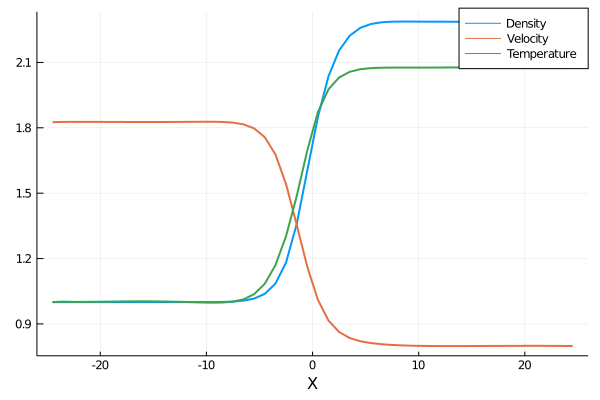

In [123]:
plot_line(ks, ctr)

In [ ]:
ctr = OffsetArray{ControlVolume1D2F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx ÷ 2
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wL),
            Float32.(ks.ib.primL),
            Float32.(ks.ib.hL),
            Float32.(ks.ib.bL),
        )
    else
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wR),
            Float32.(ks.ib.primR),
            Float32.(ks.ib.hR),
            Float32.(ks.ib.bR),
        )
    end
end
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end